In [156]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import scipy.io
import pdb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import image as mpimg
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import datetime

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.regularizers import l2
from keras.layers import Reshape, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Dropout, Input, Add, Masking, Conv2D, MaxPooling2D, Concatenate, BatchNormalization, Activation, Permute
from keras import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.utils.vis_utils import plot_model
import keras.backend as backend

from scipy.signal import butter, lfilter
from scipy.signal import spectrogram
from scipy.signal import freqz
import random
from librosa.feature import melspectrogram
from librosa import power_to_db
from librosa.display import specshow
import skimage.io

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
N = 88

BATCH_SIZE = 64

SPECTROGRAM_LEN = 2344 # 235,469,2344
SPECTROGRAM_FREQS = 32
NUM_OUTPUT_CLASSES = 3

CONV_OUTPUT_LEN = 300

# Define the seed
SEED = 2021

# Min-max of frequencies
fmin = 0.5
fmax = 45

In [3]:
shared_conv1 = Conv2D(filters=8, kernel_size=3, padding='same')
shared_bn1 = BatchNormalization()
shared_relu1 = Activation('relu')
shared_mp1 = MaxPooling2D(pool_size=4, strides=4)
shared_do1 = Dropout(0.2)

shared_conv2 = Conv2D(filters=16, kernel_size=3, padding='same')
shared_bn2 = BatchNormalization()
shared_relu2 = Activation('relu')
shared_mp2 = MaxPooling2D(pool_size=4, strides=4)
shared_do2 = Dropout(0.2)

shared_flatten = Flatten()

shared_dense1 = Dense(units=CONV_OUTPUT_LEN)
shared_bn4 = BatchNormalization()
shared_relu4 = Activation('relu')

In [4]:
# Load the EEG data (undecomposed and decomposed)
eeg = []
eeg_decomposed = []
for i in range(N):
    eeg.append(scipy.io.loadmat(f"/kaggle/input/eeg-dementia/sub-0{'0' if i < 9 else ''}{i+1}_task-eyesclosed_eeg.mat")['eegdata'])
    #eeg_decomposed.append(decompose_to_5(eeg[i]))

participants = pd.read_csv("/kaggle/input/eeg-dementia/participants.tsv", sep='\t')
groups = participants["Group"]

# One-hot encode the target label
#groups = F.one_hot(torch.tensor(pd.Categorical(participants["Group"]).codes).to(torch.int64), num_classes=3)

In [5]:
#all EEG data is 500Hz sampling rate
FS = 500

#define Mel Spectrogram parameters
n_fft = 256
hop_length = 64
n_mels = 32

In [178]:
def performance_metrics(true, predictions, labels):
    #loop over each row, and then get the index corresponding to the max probability
    predictions_class = []
    for prediction in predictions:
        predictions_class.append(np.argmax(prediction))

    #repeat for the true labels
    true_class = []
    for true_row in y_test:
        true_class.append(np.argmax(true_row))

    #calculate confusion matrix
    conf_mat = confusion_matrix(true_class, predictions_class)
    conf_mat = pd.DataFrame(conf_mat, columns=labels, index=labels)

    #calculate per class f1
    f1 = f1_score(true_class, predictions_class, average=None)
    f1 = pd.Series(f1, index=labels)

    return conf_mat, f1, predictions_class, true_class

In [ ]:
def calculate_spectrograms(eegs):
    #store sets of 5 spectrograms
    spectrogram_list = []
    do_plot = True

    for eeg in eegs:
        df = pd.DataFrame([electrode for electrode in eeg])
        spectrogram_list_tmp = []

        #load 5 thirty-second blocks of EEG data
        #apply bandpass filters on each block, and then calculate the spectrogram
        ind = 0
        while(ind < len(df.columns)):
            #grab 30 seconds of data
            df_tmp = df.loc[:,ind:ind+FS*SPEC_LEN]
            ch_tmp = []
            for i in range(len(df)):
                ch_tmp.append(df_tmp.loc[i])

            #subtract mean, unit variance
            #sometimes there is garbage data that is flatlined constant, in which case the std is zero
            #catch the warning and throw away the whole 5 block group
            try:
                for i in range(len(df)):
                    ch_tmp[i] = (ch_tmp[i]-np.mean(ch_tmp[i]))/np.std(ch_tmp[i])
            except Exception as e:
                spectrogram_list_tmp = []
                ind = ind + FS*SPEC_LEN
                continue
                
            #calculate mel spectrograms
            Sxxs = []
            
            for i in range(len(df)):
                Sxxs.append(melspectrogram(y=ch_tmp[i].to_numpy(), sr=FS, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels))
                Sxxs[i] = power_to_db(Sxxs[i], ref=np.max)
            
            #if do_plot and (ind==FS*SPEC_LEN*5):
            #    do_plot = False
            #    fig, ax = plt.subplots(figsize=(10,6))
            #    axs = []
            #    for i in range(len(df)):
            #        axs.append(plt.subplot(211 + i))
            #        img = specshow(Sxxs[i], sr=FS, hop_length=hop_length, x_axis='time', y_axis='linear')
            #        fig.colorbar(img, ax=axs[i], format="%+2.f dB")
            #        plt.ylabel(f'Frequency (Hz)\nCh{i+1}')
                    #ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
                    #img = specshow(Sxx2, sr=FS, hop_length=hop_length, x_axis='time', y_axis='linear')
                    #fig.colorbar(img, ax=ax2, format="%+2.f dB")
                    #plt.ylabel('Frequency (Hz)\nCh2')
            #    plt.xlabel('Time (Seconds)')
            #    plt.tight_layout()
            #    plt.savefig('spectrogram.png', dpi=150)
            #    plt.show()

            spectrogram_list_tmp.append(tuple(Sxxs))
            ind = ind + FS*SPEC_LEN

            if len(spectrogram_list_tmp) == 5:
                spectrogram_list.append(spectrogram_list_tmp)

                spectrogram_list_tmp = []
                
    return spectrogram_list

In [7]:
# Create 10 blocks of 30-s EEG data, 5 blocks of 60-s, and 1 block of 300-s
SPEC_LENS = [30, 60, 300]
BLOCKS = [10, 5, 1]

In [46]:
#Version 2
# n - how many blocks to generate
# k - the length of the block
# tot - the length of time series data
def random_ranges(n, k, tot):
    start_points = sorted([random.randint(0, tot-k) for _ in range(n)])
    end_points = [start + k for start in start_points]
    for i in range(1, n):
        if start_points[i] <= end_points[i-1]:
            start_points[i] = end_points[i-1] + 1
            end_points[i] = start_points[i] + k
    return [(start, end) for start, end in zip(start_points, end_points)]

def calculate_spectrograms(eegs, spec_lens, blocks, no_convert=False):
    spectrogram_list_by_len = []
    
    for a,spec_len in enumerate(spec_lens):
        spectrogram_list = []
        for eeg in eegs:
            df = pd.DataFrame([electrode for electrode in eeg])
            
            # Generate random ranges
            np.random.seed(SEED)
            ranges = random_ranges(blocks[a], FS*spec_len, df.shape[1])
            specs = []
            for rang in ranges:
                if rang[1] - rang[0] != FS*spec_len:
                    raise ValueError("not right")
                # Randomly pick blocks of intervals of spectrogram
                sample = df.loc[:, rang[0]:rang[1]]
                electrodes = []
                for i in range(len(df)):
                    electrodes.append(sample.loc[i])

                specs_tmp = []

                for (i,electrode) in enumerate(electrodes):
                    electrode = (electrode-electrode.mean())/electrode.std()
                    # Whether to convert the data into spectrogram or not
                    if no_convert == False:
                        # Include 0.5-45Hz
                        specs_tmp.append(melspectrogram(y=electrode.to_numpy(), sr=FS, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmin=fmin, fmax=fmax))
                        specs_tmp[i] = power_to_db(specs_tmp[i], ref=np.max)
                    else:
                        specs_tmp.append(electrode.to_numpy())
                        
                specs.append(specs_tmp)
            
            spectrogram_list.append(tuple(specs))
        spectrogram_list_by_len.append(spectrogram_list)
    return spectrogram_list_by_len

In [33]:
random_ranges(10, FS*30, 299900)

[(21093, 36093),
 (36094, 51094),
 (77949, 92949),
 (118492, 133492),
 (140135, 155135),
 (162413, 177413),
 (220328, 235328),
 (235329, 250329),
 (250330, 265330),
 (269553, 284553)]

In [ ]:
!ls

In [9]:
def build_cnn(inputs, num_channels):
    #build a cnn per channel
    cnn_outputs = []
    for i in range(num_channels):
        cnn_outputs.append(build_cnn_per_channel(inputs, i))

    #concatenate each channel's output
    cnn_output = Concatenate(axis=1)(cnn_outputs)
    cnn_output = Reshape((1,CONV_OUTPUT_LEN*num_channels))(cnn_output)

    return cnn_output


def build_cnn_per_channel(inputs, ch):
    cnn_output = shared_conv1(inputs[:,:,:,ch][...,None])
    cnn_output = shared_bn1(cnn_output)
    cnn_output = shared_relu1(cnn_output)
    cnn_output = shared_mp1(cnn_output)
    cnn_output = shared_do1(cnn_output)
    cnn_output = shared_conv2(cnn_output)
    cnn_output = shared_bn2(cnn_output)
    cnn_output = shared_relu2(cnn_output)
    cnn_output = shared_mp2(cnn_output)
    cnn_output = shared_do2(cnn_output)
    cnn_output = shared_flatten(cnn_output)
    cnn_output = shared_dense1(cnn_output)
    cnn_output = shared_bn4(cnn_output)
    cnn_output = shared_relu4(cnn_output)
    cnn_output = Reshape((1,CONV_OUTPUT_LEN))(cnn_output)
    #cnn_output = Reshape((1,30))(cnn_output)
    return cnn_output

In [133]:
# Create the dataset and split into train and valid-test then divide valid and test equally

def load_data(dataset, labels, batch_size, validation_split, random_seed, shuffle_dataset=True, spectrogram=True):
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    
    valid_test_split = int(np.floor(len(val_indices)/2))
    val_indices, test_indices = val_indices[valid_test_split:], val_indices[:valid_test_split]
    
    X = []
    y = []
    
    for i in indices:
        X_tmp = []
        for a,electrode in enumerate(dataset[i]):
            X_tmp.append(electrode)
        if spectrogram:
            X.append(np.array(X_tmp).reshape(SPECTROGRAM_FREQS, SPECTROGRAM_LEN, len(X_tmp)))
        else: X.append(np.array(X_tmp))
        y.append(labels[i])
    y = pd.get_dummies(y)
    
    # Split
    X_train = np.array(X)[train_indices]
    X_val = np.array(X)[val_indices]
    X_test = np.array(X)[test_indices]
    
    y_train = np.array(y)[train_indices]
    y_val = np.array(y)[val_indices]
    y_test = np.array(y)[test_indices]
    
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [108]:
eeg_spec = calculate_spectrograms(eeg, SPEC_LENS, BLOCKS)

/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=256 is too large for input signal of length=0
  warnings.warn(


In [47]:
eeg_time = calculate_spectrograms(eeg, SPEC_LENS, BLOCKS, no_convert=True)


KeyboardInterrupt



/tmp/ipykernel_32/1665647435.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(211)


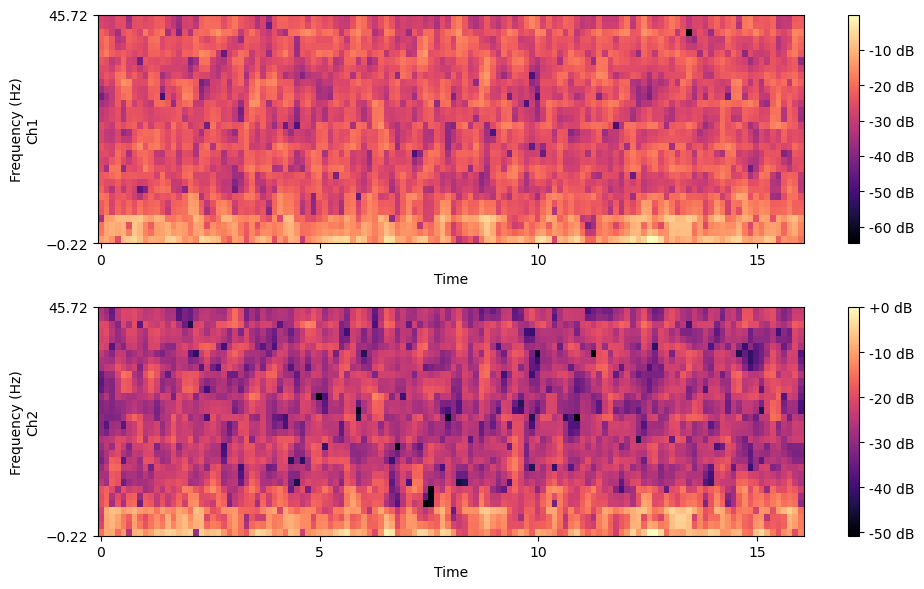

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
ax1 = plt.subplot(211)
img = specshow(eeg_spec[0][0][8][0], sr=FS, hop_length=hop_length, x_axis='time', y_axis='mel', fmin=fmin, fmax=fmax)
fig.colorbar(img, ax=ax1, format="%+2.f dB")
plt.ylabel(f'Frequency (Hz)\nCh1')
ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
img = specshow(eeg_spec[0][0][8][1], sr=FS, hop_length=hop_length, x_axis='time', y_axis='mel', fmin=fmin, fmax=fmax)
fig.colorbar(img, ax=ax2, format="%+2.f dB")
plt.ylabel('Frequency (Hz)\nCh2')
plt.tight_layout()
#plt.savefig('spectrogram.png', dpi=150)
plt.show()

In [17]:
# Save the spectrogram images
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def save_specimg(spec,filename):
    # min-max scale to fit inside 8-bit range
    img = scale_minmax(spec, 0, 255).astype(np.uint8)
    #img = scale_minmax(spec)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy
    #img = 1-img

    # save as PNG
    skimage.io.imsave(filename, img)

In [75]:
# Loop over different lengths
for i,spec_by_len in enumerate([eeg_spec[2]]):
    # Loop over different participants
    for j,spec in enumerate(spec_by_len):
        # Loop over different blocks
        for k, block in enumerate(spec):
            # Loop over different electrodes
            for l, electrode in enumerate(block):
                save_specimg(electrode, f"spec-0{'0' if j < 9 else ''}{j+1}-{SPEC_LENS[2]}sec-ch{l+1}-block{k+1}.png")

In [76]:
!ls

spec-001-300sec-ch1-block1.png	 spec-045-300sec-ch10-block1.png
spec-001-300sec-ch10-block1.png  spec-045-300sec-ch11-block1.png
spec-001-300sec-ch11-block1.png  spec-045-300sec-ch12-block1.png
spec-001-300sec-ch12-block1.png  spec-045-300sec-ch13-block1.png
spec-001-300sec-ch13-block1.png  spec-045-300sec-ch14-block1.png
spec-001-300sec-ch14-block1.png  spec-045-300sec-ch15-block1.png
spec-001-300sec-ch15-block1.png  spec-045-300sec-ch16-block1.png
spec-001-300sec-ch16-block1.png  spec-045-300sec-ch17-block1.png
spec-001-300sec-ch17-block1.png  spec-045-300sec-ch18-block1.png
spec-001-300sec-ch18-block1.png  spec-045-300sec-ch19-block1.png
spec-001-300sec-ch19-block1.png  spec-045-300sec-ch2-block1.png
spec-001-300sec-ch2-block1.png	 spec-045-300sec-ch3-block1.png
spec-001-300sec-ch3-block1.png	 spec-045-300sec-ch4-block1.png
spec-001-300sec-ch4-block1.png	 spec-045-300sec-ch5-block1.png
spec-001-300sec-ch5-block1.png	 spec-045-300sec-ch6-block1.png
spec-001-300sec-ch6-block1.png	 spe

In [77]:
eeg_specs_by_len = []

# Loop over different lengths
for i in [SPEC_LENS[2]]:
    eeg_specs_participants = []
    # Loop over different participants
    for j in range(N):
        eeg_specs_blocks = []
        # Loop over different blocks
        for k in range(BLOCKS[2]):
            eeg_specs_electrodes = []
            # Loop over different electrodes
            for l in range(19):
                eeg_specs_electrodes.append(mpimg.imread(f"spec-0{'0' if j < 9 else ''}{j+1}-{i}sec-ch{l+1}-block{k+1}.png"))
            eeg_specs_blocks.append(eeg_specs_electrodes)
        eeg_specs_participants.append(eeg_specs_blocks)
    eeg_specs_by_len.append(eeg_specs_participants)

In [139]:
np.array(eeg_specs_by_len)[0,:,0,:,:,:].shape

(88, 19, 32, 2344)

In [140]:
X_train, X_val, X_test, y_train, y_val, y_test = load_data(np.array(eeg_specs_by_len)[0,:,0,:,:,:], groups, BATCH_SIZE, 0.2, SEED)

In [141]:
np.max(X_train)

1.0

In [142]:
y_val

array([[0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [ ]:
X_train

In [150]:
inputs = []
cnn_outputs = []
for i in range(1):
    #inputs.append(Input(shape=(19, SPECTROGRAM_FREQS, SPECTROGRAM_LEN)))
    inputs.append(Input(shape=(32, 2344, 19)))
    cnn_outputs.append(build_cnn(inputs[i],19))

#combine all outputs into a single input for the LSTM
#cnn_concat = Concatenate(axis=1)(cnn_outputs)

lstm_output = Bidirectional(LSTM(15, return_sequences=False, kernel_regularizer=l2(0.01)))(cnn_outputs)
lstm_output = Dense(NUM_OUTPUT_CLASSES, activation='softmax')(lstm_output)

model = Model(inputs=inputs, outputs=lstm_output)
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

print(model.summary())
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 2344, 1  0           []                               
                                9)]                                                               
                                                                                                  
 tf.__operators__.getitem_190 (  (None, 32, 2344)    0           ['input_6[0][0]']                
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.__operators__.getitem_192 (  (None, 32, 2344)    0           ['input_6[0][0]']                
 SlicingOpLambda)                                                                           

In [144]:
X_val.shape

(9, 32, 2344, 19)

In [151]:
#change this to true to train the model again
if True:
    checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='rmsprop')
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
    history = model.fit(X_train,
                        y_train,
                        batch_size=BATCH_SIZE,
                        epochs=50,
                        validation_data=(X_val, y_val),
                        callbacks=[earlystop, checkpoint, CSVLogger('history.csv')],
                        verbose=1)


#model = load_model('/kaggle/temp/model.h5')
#history = pd.read_csv('history.csv')

Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 3.4618 - categorical_accuracy: 0.3662 
Epoch 1: val_loss improved from inf to 3.33863, saving model to model.h5
2/2 [==============================] - 33s 4s/step - loss: 3.4618 - categorical_accuracy: 0.3662 - val_loss: 3.3386 - val_categorical_accuracy: 0.3333
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 3.0596 - categorical_accuracy: 0.6338 
Epoch 2: val_loss did not improve from 3.33863
2/2 [==============================] - 18s 3s/step - loss: 3.0596 - categorical_accuracy: 0.6338 - val_loss: 3.3829 - val_categorical_accuracy: 0.3333
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: 2.8276 - categorical_accuracy: 0.6761 
Epoch 3: val_loss improved from 3.33863 to 3.32512, saving model to model.h5
2/2 [==============================] - 18s 3s/step - loss: 2.8276 - categorical_accuracy: 0.6761 - val_loss: 3.3251 - val_categorical_accuracy: 0.2222
Epoch 4/50
2/2 [===================

In [ ]:
# Another way to train the model
model.fit(X_train,
            y_train,
            batch_size=BATCH_SIZE,
            epochs=20,
            validation_data=(X_val, y_val),
            callbacks=[earlystop, checkpoint, CSVLogger('history.csv')],
            verbose=1)

In [152]:
model = load_model('model.h5')

In [154]:
history = pd.read_csv('history.csv')

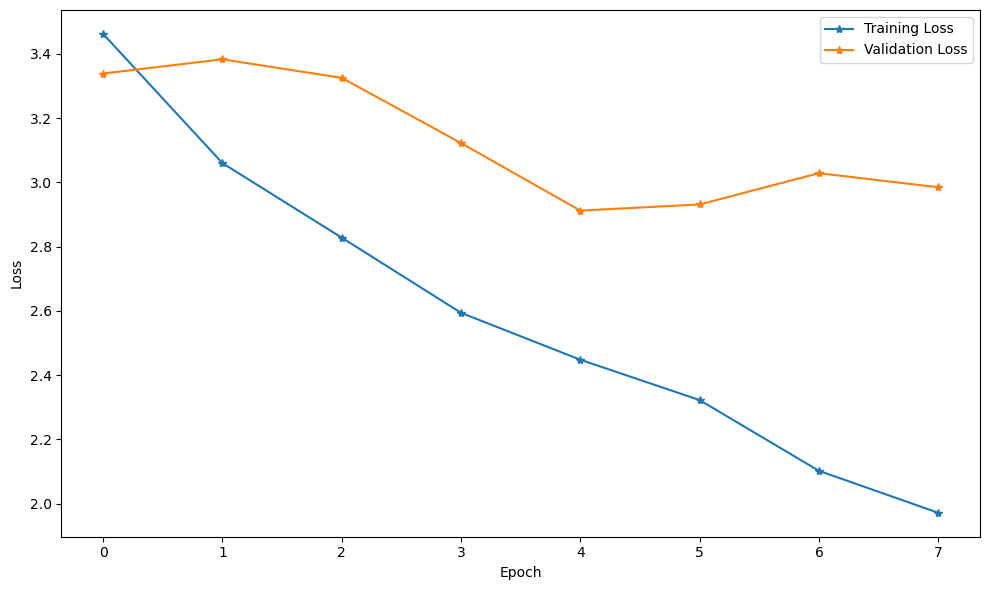

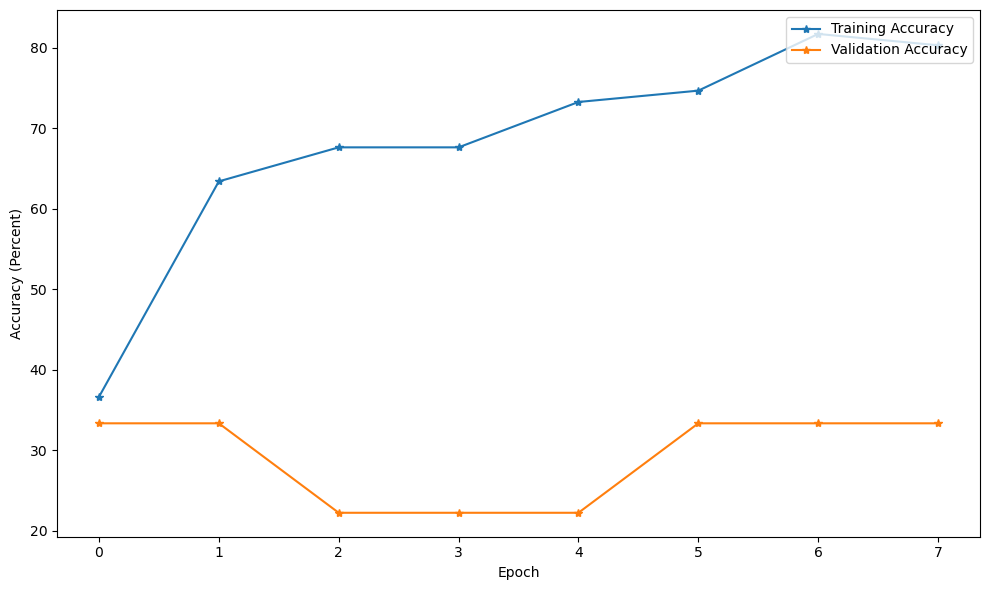

In [155]:
#plot the training and validation loss
plt.subplots(figsize=(10,6))
plt.plot(history['loss'], '*-', label='Training Loss')
plt.plot(history['val_loss'], '*-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('loss.png', dpi=150)
plt.show()

#plot the training and validation accuracy
plt.subplots(figsize=(10,6))
plt.plot(history['categorical_accuracy']*100, '*-', label='Training Accuracy')
plt.plot(history['val_categorical_accuracy']*100, '*-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (Percent)')
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('accuracy.png', dpi=150)
plt.show()

In [173]:
predictions_class = []
for prediction in predictions:
    predictions_class.append(np.argmax(prediction))

#repeat for the true labels
true_class = []
for true_row in y_test:
    true_class.append(np.argmax(true_row))

In [179]:
predictions = model.predict(X_test)

# calculate confusion matrix, f1 scores, accuracy, precision, and recall
conf_mat, f1, _, _ = performance_metrics(y_test, predictions, ['A', 'C', 'F'])

print('Confusion Matrix:')
print(conf_mat)

print('\nf1 score, per class:')
print(f1)

1/1 [==============================] - 1s 679ms/step
Confusion Matrix:
   A  C  F
A  1  2  0
C  0  4  0
F  0  1  0

f1 score, per class:
A    0.500000
C    0.727273
F    0.000000
dtype: float64


In [ ]:
# Normalize each electrode before feeding the data

In [ ]:
# Implementation of CNN model of doi 10.1159/000528439
THETA = 15000

model2 = Sequential()
model2.add(Input(shape=(19, THETA, 1))) #input
model2.add(Conv2D(filters = 40, kernel_size=(19, 4))) #conv1
model2.add(Conv2D(filters = 40, kernel_size=(1, 4))) #conv2
model2.add(BatchNormalization()) #bn2d1
model2.add(MaxPooling2D(pool_size=(1, 5), strides=(1,5))) #pool1
model2.add(Permute(dims=(3,2,1))) #Swap axes
model2.add(Conv2D(filters = 50, kernel_size=(8, 12))) #conv3
model2.add(BatchNormalization()) #bn2d2
model2.add(MaxPooling2D(pool_size=(3, 3), strides=(3,3))) #pool2
model2.add(Conv2D(filters = 50, kernel_size=(1, 5))) #conv4
model2.add(BatchNormalization()) #bn2d3
model2.add(MaxPooling2D(pool_size=(1, 2), strides=(1,2))) #pool3
model2.add(Flatten())
model2.add(Dense(units=5120)) #fcl1
model2.add(Activation('relu')) #relu
model2.add(Dropout(.85)) #dropout. 0.85 for training phase, 0 for valid and test phase
model2.add(Dense(units=256)) #fcl2
model2.add(Activation('relu')) #relu
model2.add(Dropout(.85)) #dropout. 0.85 for training phase, 0 for valid and test phase
model2.add(Dense(units=NUM_OUTPUT_CLASSES, activation='softmax')) #fcl3. output layer

model2.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

print(model2.summary())
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
print(model2.summary())
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#change this to true to train the model again
if True:
    checkpoint = ModelCheckpoint('model2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='rmsprop')
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)
    history = model.fit(X_train,
                        y_train,
                        batch_size=BATCH_SIZE,
                        epochs=20,
                        validation_data=(X_val, y_val),
                        callbacks=[earlystop, checkpoint, CSVLogger('history.csv')],
                        verbose=1)


model = load_model('model2.h5')
history = pd.read_csv('history.csv')

In [ ]:
model.save('my_model.h5')

In [ ]:
#plot the training and validation loss
plt.subplots(figsize=(10,6))
plt.plot(history['loss'], '*-', label='Training Loss')
plt.plot(history['val_loss'], '*-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('loss.png', dpi=150)
plt.show()

#plot the training and validation accuracy
plt.subplots(figsize=(10,6))
plt.plot(history['categorical_accuracy']*100, '*-', label='Training Accuracy')
plt.plot(history['val_categorical_accuracy']*100, '*-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (Percent)')
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('accuracy.png', dpi=150)
plt.show()